# Project 5: COVID-19 Hospitalization Analysis Project

### Problem Statement: 
Can we predict which COVID-19 probable cases will be admitted to the hospital?

We will use a variety of classifiers to develop our models. Success will be evaluated on our accuracy of predicting whether a person was hospitalized or not. It will be interesting to see what factors influence the probability of hospitalization.

Our target audience for this presentation was for hospitals around the United States in order for them to prepare for potential increases in hospitalizations. More specifically, we are directing the project towards a more technical staff at each hopsital who would understand our analysis and can use outcome to inform others on their teams.

## Executive Summary

### Contents:
[1) Reading in the Data](#Reading-in-the-Data)<br>
[2) Data Cleaning](#Data-Cleaning)<br>
[3) EDA & Feature Selection](#EDA-&-Feature-Selection)<br>
[4) Testing Various Models](#Testing-Various-Models)<br>
[5) Final Model Selection & Evaluation](#Final-Model-Selection-&-Evaluation)<br>
[6) Conclusions & Recommendations](#Conclusions-&-Recommendations)<br>
[7) Areas for Further Research/Study](#Areas-for-Further-Research/Study)

In [1]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import tensorflow

from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, accuracy_score

<a id='Reading-in-the-Data'></a>

### 1) Reading in the Data

We gathered/collected our COVID data directly from the Center for Disease Control and Prevention website, where all available data sets are public.
We were interested in predicting whether a COVID-19 probable cases will be admitted to the hospital based on the gathered data. The data set contained over 10 million submissions of covid cases from 2019 to 2021 across the United States. 

In [2]:
df = pd.read_csv('./data/covid_cases_cleaned.csv')

<a id='Data-Cleaning'></a>

### 2) Data Cleaning

In [3]:
hosp_df = df.copy()

In [4]:
#removing unneccesary columns and any with over 80% null values that won't help us in building our model
hosp_df.drop(['Unnamed: 0', 'state_fips_code', 'county_fips_code', 'underlying_conditions_yn', 'icu_yn', 'process', 'exposure_yn', 'case_positive_specimen_interval', 'res_county'], axis = 1, inplace = True)

In [5]:
hosp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10482259 entries, 0 to 10482258
Data columns (total 11 columns):
 #   Column               Dtype  
---  ------               -----  
 0   case_month           object 
 1   res_state            object 
 2   age_group            object 
 3   sex                  object 
 4   race                 object 
 5   ethnicity            object 
 6   case_onset_interval  float64
 7   current_status       object 
 8   symptom_status       object 
 9   hosp_yn              object 
 10  death_yn             object 
dtypes: float64(1), object(10)
memory usage: 879.7+ MB


In [6]:
hosp_df.head()

,case_month,res_state,age_group,sex,race,ethnicity,case_onset_interval,current_status,symptom_status,hosp_yn,death_yn
0,2021-03,NY,0 - 17 years,Female,American Indian/Alaska Native,Hispanic/Latino,0.0,Probable Case,Symptomatic,NaN,NaN
1,2021-03,NY,0 - 17 years,Female,American Indian/Alaska Native,Hispanic/Latino,0.0,Probable Case,Symptomatic,NaN,NaN
2,2021-03,NY,0 - 17 years,Female,American Indian/Alaska Native,Hispanic/Latino,NaN,Probable Case,Asymptomatic,NaN,NaN
3,2021-03,NY,0 - 17 years,Female,American Indian/Alaska Native,Hispanic/Latino,0.0,Probable Case,Symptomatic,NaN,NaN
4,2021-03,NY,0 - 17 years,Female,American Indian/Alaska Native,Hispanic/Latino,NaN,Laboratory-confirmed case,NaN,NaN,NaN


In [7]:
#convert binary columns
hosp_df['is_male'] = np.where(hosp_df['sex'] == 'Male', 1, 0)
hosp_df['hosp_yn'] = np.where(hosp_df['hosp_yn'] == 'Yes', 1, 0)

In [8]:
hosp_df = hosp_df.drop(columns = 'sex')

In [9]:
#add a count column to allow for data inspection later on
hosp_df['count'] = 1

In [10]:
hosp_df.head()

,case_month,res_state,age_group,race,ethnicity,case_onset_interval,current_status,symptom_status,hosp_yn,death_yn,is_male,count
0,2021-03,NY,0 - 17 years,American Indian/Alaska Native,Hispanic/Latino,0.0,Probable Case,Symptomatic,0,NaN,0,1
1,2021-03,NY,0 - 17 years,American Indian/Alaska Native,Hispanic/Latino,0.0,Probable Case,Symptomatic,0,NaN,0,1
2,2021-03,NY,0 - 17 years,American Indian/Alaska Native,Hispanic/Latino,NaN,Probable Case,Asymptomatic,0,NaN,0,1
3,2021-03,NY,0 - 17 years,American Indian/Alaska Native,Hispanic/Latino,0.0,Probable Case,Symptomatic,0,NaN,0,1
4,2021-03,NY,0 - 17 years,American Indian/Alaska Native,Hispanic/Latino,NaN,Laboratory-confirmed case,NaN,0,NaN,0,1


In [11]:
hosp_df.isna().sum()

case_month                   0
res_state                    0
age_group                    0
race                         0
ethnicity                    0
case_onset_interval    4456065
current_status               0
symptom_status         4568268
hosp_yn                      0
death_yn               4714030
is_male                      0
count                        0
dtype: int64

In [12]:
#remove rows with remaining null values
hosp_clean = hosp_df.dropna()

In [13]:
hosp_clean.isna().sum()

case_month             0
res_state              0
age_group              0
race                   0
ethnicity              0
case_onset_interval    0
current_status         0
symptom_status         0
hosp_yn                0
death_yn               0
is_male                0
count                  0
dtype: int64

<a id='EDA-&-Feature-Selection'></a>

### 3) EDA & Feature Selection

#### Analysis on State Hospitalization/Death Rate

In [14]:
hosp_df.groupby(by = ['res_state', 'death_yn']).size().reset_index().groupby(['res_state', 'death_yn']).sum().drop(['AK', 'WA', 'RI'])

0
res_state death_yn        
AL        No         58795
          Yes         2289
AR        No         86662
          Yes         1343
AZ        No        220746
...                    ...
VA        Yes         2237
VT        No         10882
          Yes           31
WI        No        144317
          Yes         2909

[72 rows x 1 columns]

In [15]:
final2 = df.groupby(by = ['res_state', 'hosp_yn']).size().reset_index().groupby(['res_state', 'hosp_yn']).sum().drop(['HI', 'MD', 'WV', 'SD', 'RI', 'NM'])

final_final2 = pd.DataFrame(final2[1::2].reset_index().drop('hosp_yn', axis = 1)[0] / (final2[0::2].reset_index().drop('hosp_yn', axis = 1)[0] + final2[1::2].reset_index().drop('hosp_yn', axis = 1)[0]))

final_final2['res_state'] = final2[1::2].reset_index()['res_state']

final_final2['rate'] = final_final2[0]

final_final2.drop(0, axis = 1)

,res_state,rate
0,AK,0.228302
1,AL,0.071554
2,AR,0.076226
3,AZ,0.191451
4,CA,0.181990
5,CO,0.154666
6,CT,0.300079
7,FL,0.075167
8,GA,0.359354
9,IA,0.048581


#### Folium

In [16]:
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
state_geo = f'{url}/us-states.json'

In [17]:
p = folium.Map(location = [39.8283, -98.5795], zoom_start = 5)

In [18]:
folium.Choropleth(
                geo_data = state_geo,
                data = final_final2,
                columns = ['res_state', 'rate'],
                key_on = 'feature.id',
                legend_name = 'hospitilization_rate',
                fill_color = 'OrRd').add_to(p)

In [19]:
p

#### Analysis on Age Hospitalization/Death Rate

In [20]:
total_by_age = pd.DataFrame(hosp_df.groupby('age_group')['count'].sum())
by_age = pd.DataFrame(hosp_df.groupby('age_group')['hosp_yn'].sum())
ages = pd.merge(total_by_age, by_age, left_index = True, right_index = True)
ages.reset_index(inplace = True)
ages['percent'] = round((ages['hosp_yn']/ages['count']*100),0)
ages

,age_group,count,hosp_yn,percent
0,0 - 17 years,1106353,10177,1.0
1,18 to 49 years,5587345,145127,3.0
2,50 to 64 years,2142334,171270,8.0
3,65+ years,1646227,370795,23.0


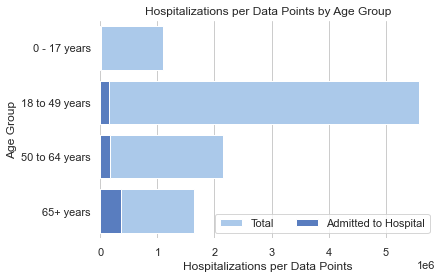

In [21]:
sns.set_theme(style='whitegrid')

# Initialize the matplotlib figure
f, ax = plt.subplots()

# Plot total data points
sns.set_color_codes('pastel')
sns.barplot(x='count', y='age_group', data=ages,
            label='Total', color='b')

# Plot the hospitalizations
sns.set_color_codes('muted')
sns.barplot(x='hosp_yn', y='age_group', data=ages,
            label='Admitted to Hospital', color='b')

# Add a legend and informative axis label
ax.legend(ncol=2, loc='lower right', frameon=True)
ax.set_ylabel('Age Group'),
ax.set_xlabel('Hospitalizations per Data Points')
ax.set_title('Hospitalizations per Data Points by Age Group')
sns.despine(left=True, bottom=True)

plt.savefig('./images/age_hospitalizations.jpg', bbox_inches='tight', dpi=100)

#### Analysis on Gender Hospitalization/Death Rate

In [22]:
total_by_gender = pd.DataFrame(hosp_df.groupby('is_male')['count'].sum())
by_gender = pd.DataFrame(hosp_df.groupby('is_male')['hosp_yn'].sum())
gender = pd.merge(total_by_gender, by_gender, left_index = True, right_index = True)
gender.reset_index(inplace = True)
gender['is_male'].replace({0: 'Female', 1: 'Male'}, inplace = True)
gender['percent'] = round((gender['hosp_yn']/gender['count']*100),0)
gender

,is_male,count,hosp_yn,percent
0,Female,5619261,335589,6.0
1,Male,4862998,361780,7.0


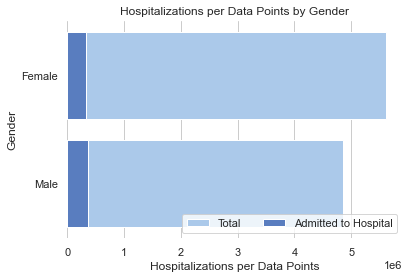

In [23]:
sns.set_theme(style='whitegrid')

# Initialize the matplotlib figure
f, ax = plt.subplots()

# Plot total data points
sns.set_color_codes('pastel')
sns.barplot(x='count', y='is_male', data=gender,
            label='Total', color='b')

# Plot the hospitalizations
sns.set_color_codes('muted')
sns.barplot(x='hosp_yn', y='is_male', data=gender,
            label='Admitted to Hospital', color='b')

# Add a legend and informative axis label
ax.legend(ncol=2, loc='lower right', frameon=True)
ax.set_ylabel('Gender'),
ax.set_xlabel('Hospitalizations per Data Points')
ax.set_title('Hospitalizations per Data Points by Gender')
sns.despine(left=True, bottom=True)

plt.savefig('./images/gender_hospitalizations.jpg', bbox_inches='tight', dpi=100)

Through EDA we learned which variables had the biggest effect on our outcome. With the folium map we see that New York and Minnesota had the highest hospitalizations rates, 66% for NY and 63% for MN. The grey states did not have enough data to create an accurate measure.  Age is a huge factor in determing whether or not a case will be admitted to a hospital, with the chance increasing as one gets older. Gender also has an effect, with men having a higher rate than women. These are all important features to consider when building our model.

<a id='Testing-Various-Models'></a>

### 4) Testing Various Models

Our cleaned dataframe has 3.7 million rows, so in order to test which model performs best we will create a smaller sample of 10,000. This will save time and allow us to try more versions before training on the complete dataframe.

Other than looking at accuracy, we want to aim for low false negatives to minimize how many times we predict a non-hospital case that is actually more serious.

In [88]:
sample_df = hosp_clean.sample(10_000)
sample_df.shape

(10000, 12)

In [89]:
X = sample_df.drop(columns = ['hosp_yn', 'death_yn', 'count'])
y = sample_df['hosp_yn']

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [91]:
y_test.value_counts(normalize = True)

0    0.9264
1    0.0736
Name: hosp_yn, dtype: float64

In [92]:
y_test.value_counts()

0    2316
1     184
Name: hosp_yn, dtype: int64

The baseline for this sample set is 92.6%. It is equivalent to saying that all 2,500 cases in the test set are not going to the hospital, and would result in 184 false negatives. If converted to our entire data set, this would account for almost 66k false negatives.

We found that One Hot Encoding the categorical columns and scaling the data outside of a pipeline saves time and allows for a shorter code in the model testing.

In [93]:
ohe = OneHotEncoder()
X_train_encoded = ohe.fit_transform(X_train)
X_test_encoded = ohe.transform(X_test)

C:\Users\Lindsey\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [94]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train_encoded)
X_test_scaled = ss.transform(X_test_encoded)

#### Model 1: Logistic Regression

In [95]:
logr = LogisticRegression()
logr.fit(X_train_scaled, y_train)
logr.score(X_test_scaled, y_test)

0.9284

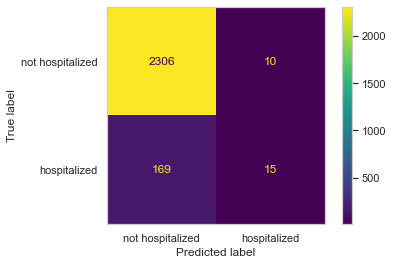

In [96]:
plot_confusion_matrix(logr, X_test_scaled, y_test, display_labels = ['not hospitalized', 'hospitalized'])
plt.grid(None)

#### Model 2: K Nearest Neighbors

In [97]:
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
knn.score(X_test_scaled, y_test)

0.9236

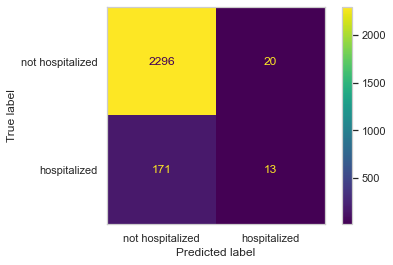

In [98]:
plot_confusion_matrix(knn, X_test_scaled, y_test, display_labels = ['not hospitalized', 'hospitalized'])
plt.grid(None)

#### Model 3: Decision Tree

In [99]:
tree = DecisionTreeClassifier(max_depth = 25)
tree.fit(X_train_scaled, y_train)
tree.score(X_test_scaled, y_test)

0.9108

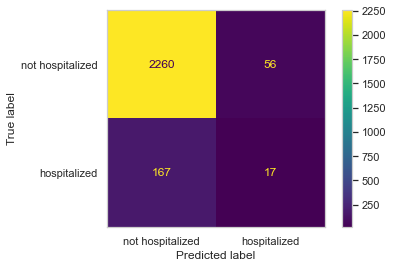

In [100]:
plot_confusion_matrix(tree, X_test_scaled, y_test, display_labels = ['not hospitalized', 'hospitalized'])
plt.grid(None)

#### Model 4: Bagging with KNN

In [101]:
bag = BaggingClassifier(base_estimator = KNeighborsClassifier())
bag.fit(X_train_scaled, y_train)
bag.score(X_test_scaled, y_test)

0.9244

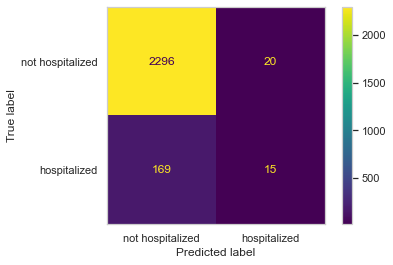

In [102]:
plot_confusion_matrix(bag, X_test_scaled, y_test, display_labels = ['not hospitalized', 'hospitalized'])
plt.grid(None)

#### Model 5: Bagging with Random Forest

In [103]:
bag2 = BaggingClassifier(base_estimator = RandomForestClassifier())
bag2.fit(X_train_scaled, y_train)
bag2.score(X_test_scaled, y_test)

0.922

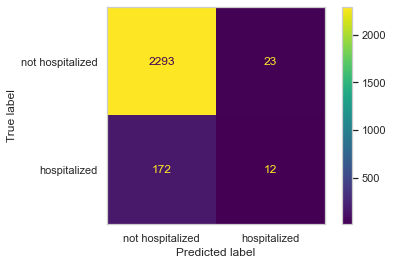

In [104]:
plot_confusion_matrix(bag2, X_test_scaled, y_test, display_labels = ['not hospitalized', 'hospitalized'])
plt.grid(None)

#### Model 6: Bagging with Decision Tree

In [105]:
bag3 = BaggingClassifier(base_estimator = DecisionTreeClassifier())
bag3.fit(X_train_scaled, y_train)
bag3.score(X_test_scaled, y_test)

0.9124

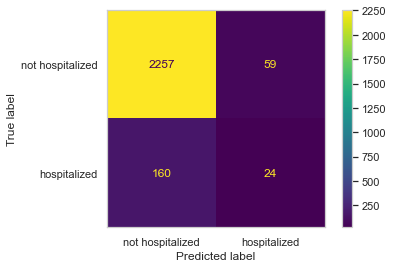

In [106]:
plot_confusion_matrix(bag3, X_test_scaled, y_test, display_labels = ['not hospitalized', 'hospitalized'])
plt.grid(None)

#### Model 7: Ada Boosting

In [107]:
aboost = AdaBoostClassifier()
aboost.fit(X_train_scaled, y_train)
aboost.score(X_test_scaled, y_test)

0.9284

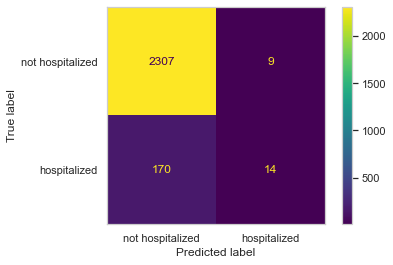

In [108]:
plot_confusion_matrix(aboost, X_test_scaled, y_test, display_labels = ['not hospitalized', 'hospitalized'])
plt.grid(None)

#### Model 8: Random Forest

In [109]:
forest = (RandomForestClassifier(max_depth = 25))
forest.fit(X_train_scaled, y_train)
forest.score(X_test_scaled, y_test)

0.9172

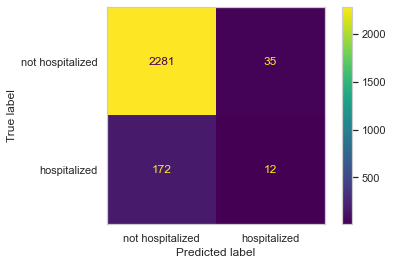

In [110]:
plot_confusion_matrix(forest, X_test_scaled, y_test, display_labels = ['not hospitalized', 'hospitalized'])
plt.grid(None)

#### Model 9: Nueral Network (simple)

In [111]:
model = Sequential()
model.add(Dense(100, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid')) 
# Compile it
model.compile(loss = 'bce', metrics = ['accuracy'], optimizer = 'adam')


# Fit it
history = model.fit(X_train_scaled, 
                    y_train, 
                    validation_data = (X_test_scaled, y_test),
                    epochs = 5)

Epoch 1/5
235/235 [==============================] - 0s 2ms/step - loss: 0.2498 - accuracy: 0.9244 - val_loss: 0.2319 - val_accuracy: 0.9280
Epoch 2/5
235/235 [==============================] - 0s 1ms/step - loss: 0.2150 - accuracy: 0.9303 - val_loss: 0.2280 - val_accuracy: 0.9272
Epoch 3/5
235/235 [==============================] - 0s 1ms/step - loss: 0.2053 - accuracy: 0.9312 - val_loss: 0.2305 - val_accuracy: 0.9280
Epoch 4/5
235/235 [==============================] - 0s 1ms/step - loss: 0.2000 - accuracy: 0.9336 - val_loss: 0.2312 - val_accuracy: 0.9272
Epoch 5/5
235/235 [==============================] - 0s 1ms/step - loss: 0.1949 - accuracy: 0.9335 - val_loss: 0.2376 - val_accuracy: 0.9212


In [112]:
probs = history.model.predict(X_test_scaled)
preds = np.where(probs >= 0.5, 1, 0)
preds

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [113]:
cm = confusion_matrix(y_test, preds)
cm

array([[2274,   42],
       [ 155,   29]], dtype=int64)

#### Model 9: Nueral Network (complex)

In [114]:
model2 = Sequential()

model2.add(Dense(10, activation = 'relu'))
model2.add(Dropout(0.5))

model2.add(Dense(100, activation = 'relu'))
model2.add(Dropout(0.8))

model2.add(Dense(1, activation = 'sigmoid'))

# Compile it

model2.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer = 'adam')

# Fit it

history2 = model2.fit(X_train_scaled, y_train, validation_data = (X_test_scaled, y_test), epochs = 10)

Epoch 1/10
235/235 [==============================] - 0s 2ms/step - loss: 0.3733 - accuracy: 0.9021 - val_loss: 0.2747 - val_accuracy: 0.9264
Epoch 2/10
235/235 [==============================] - 0s 2ms/step - loss: 0.3020 - accuracy: 0.9245 - val_loss: 0.2610 - val_accuracy: 0.9264
Epoch 3/10
235/235 [==============================] - 0s 2ms/step - loss: 0.2819 - accuracy: 0.9259 - val_loss: 0.2535 - val_accuracy: 0.9264
Epoch 4/10
235/235 [==============================] - 0s 1ms/step - loss: 0.2729 - accuracy: 0.9261 - val_loss: 0.2499 - val_accuracy: 0.9264
Epoch 5/10
235/235 [==============================] - 0s 2ms/step - loss: 0.2644 - accuracy: 0.9264 - val_loss: 0.2473 - val_accuracy: 0.9264
Epoch 6/10
235/235 [==============================] - 0s 1ms/step - loss: 0.2580 - accuracy: 0.9264 - val_loss: 0.2451 - val_accuracy: 0.9264
Epoch 7/10
235/235 [==============================] - 0s 1ms/step - loss: 0.2556 - accuracy: 0.9263 - val_loss: 0.2438 - val_accuracy: 0.9264
Epoch 

In [115]:
probs2 = history2.model.predict(X_test_scaled)
preds2 = np.where(probs2 >= 0.5, 1, 0)
preds2

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [116]:
cm = confusion_matrix(y_test, preds2)
cm

array([[2316,    0],
       [ 184,    0]], dtype=int64)

<a id='Final-Model-Selection-&-Evaluation'></a>

### 5) Final Model Selection & Evaluation

Logistic Regression had the highest accuracy and one of the lowest False Negatives. While bagging achieved a lower false negative rate on average, we found these models took longer to run and would create a problem when fitting to the final training set.

In [117]:
pipe = make_pipeline(PolynomialFeatures(), 
                  LogisticRegression(n_jobs = -1, max_iter = 1000))

In [118]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'polynomialfeatures', 'logisticregression', 'polynomialfeatures__degree', 'polynomialfeatures__include_bias', 'polynomialfeatures__interaction_only', 'polynomialfeatures__order', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregression__warm_start'])

In [119]:
params = {
    'polynomialfeatures__interaction_only': [True, False],
    'logisticregression__C': [0.1, 1, 10]
}

In [120]:
gs = GridSearchCV(pipe, params)

In [121]:
gs.fit(X_train_scaled, y_train)

GridSearchCV(estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000,
                                                           n_jobs=-1))]),
             param_grid={'logisticregression__C': [0.1, 1, 10],
                         'polynomialfeatures__interaction_only': [True, False]})

In [122]:
gs.best_params_

{'logisticregression__C': 0.1, 'polynomialfeatures__interaction_only': True}

In [123]:
gs.best_score_

0.9144

In [124]:
pd.DataFrame(gs.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_polynomialfeatures__interaction_only,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.511173,0.548144,0.026566,0.001061,0.1,True,"{'logisticregression__C': 0.1, 'polynomialfeat...",0.918667,0.912667,0.906667,0.910000,0.924000,0.914400,0.006205,1
1,9.753313,1.213895,0.027519,0.001723,0.1,False,"{'logisticregression__C': 0.1, 'polynomialfeat...",0.916000,0.912000,0.907333,0.910000,0.924000,0.913867,0.005803,2
3,15.446809,0.158059,0.028519,0.002063,1,False,"{'logisticregression__C': 1, 'polynomialfeatur...",0.912000,0.913333,0.907333,0.907333,0.919333,0.911867,0.004450,3
2,9.347159,0.846431,0.026267,0.000785,1,True,"{'logisticregression__C': 1, 'polynomialfeatur...",0.912667,0.911333,0.906000,0.908000,0.918667,0.911333,0.004361,4
5,15.507747,0.443838,0.027312,0.001205,10,False,"{'logisticregression__C': 10, 'polynomialfeatu...",0.912000,0.912667,0.903333,0.910000,0.918000,0.911200,0.004740,5
4,14.993150,0.784408,0.039289,0.016526,10,True,"{'logisticregression__C': 10, 'polynomialfeatu...",0.912000,0.908000,0.900667,0.906000,0.918667,0.909067,0.006031,6


In [125]:
pipe = make_pipeline(PolynomialFeatures(interaction_only=True), 
                     LogisticRegression(C=0.1, n_jobs = -1, max_iter = 1000))

pipe.fit(X_train_scaled, y_train)

pipe.score(X_test_scaled, y_test)

0.9144

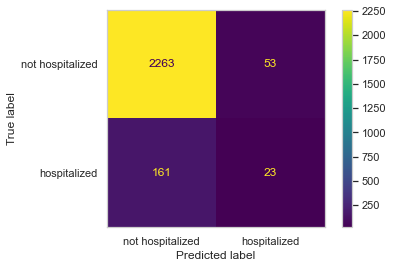

In [126]:
plot_confusion_matrix(pipe, X_test_scaled, y_test, display_labels = ['not hospitalized', 'hospitalized'])
plt.grid(None)

The score with Polynomial features is lower than the baseline.

In [127]:
logr2 = LogisticRegression(C=0.1)
logr2.fit(X_train_scaled, y_train)
logr2.score(X_test_scaled, y_test)

0.9284

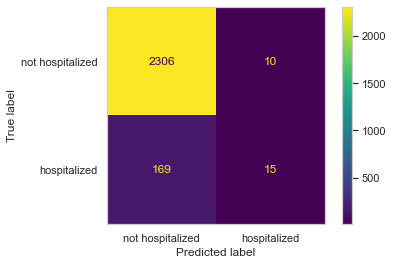

In [128]:
plot_confusion_matrix(logr2, X_test_scaled, y_test, display_labels = ['not hospitalized', 'hospitalized'])
plt.grid(None)

Logistic Regression C value of 0.1 gives us lower accuracy and increases the fale negatives, so we will leave it at the default.

#### Final Model

In [129]:
logr = LogisticRegression()
logr.fit(X_train_scaled, y_train)
logr.score(X_test_scaled, y_test)

0.9284

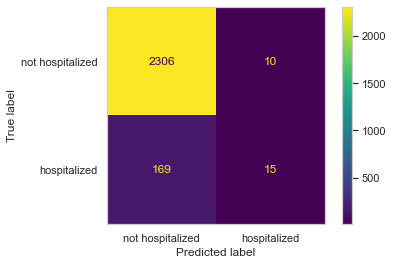

In [130]:
plot_confusion_matrix(logr, X_test_scaled, y_test, display_labels = ['not hospitalized', 'hospitalized'])
plt.grid(None)

#### Modeling on Entire Data Set

In [131]:
X2 = hosp_clean.drop(columns = ['hosp_yn', 'death_yn', 'count'])
y2 = hosp_clean['hosp_yn']

In [132]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2,stratify=y2)

In [133]:
ohe = OneHotEncoder()
X2_train_encoded = ohe.fit_transform(X2_train)
X2_test_encoded = ohe.transform(X2_test)

C:\Users\Lindsey\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [134]:
ss = StandardScaler()
X2_train_scaled = ss.fit_transform(X2_train_encoded)
X2_test_scaled = ss.transform(X2_test_encoded)

In [135]:
X2_train_encoded.shape

(2802642, 70)

In [136]:
logr_final = LogisticRegression()
logr_final.fit(X2_train_scaled, y2_train)
logr_final.score(X2_test_scaled, y2_test)

0.9317008736756246

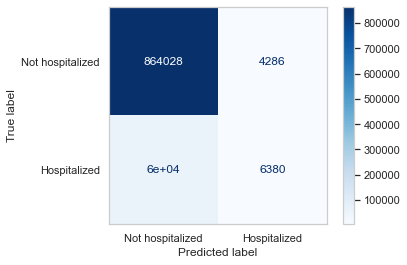

In [137]:
plot_confusion_matrix(logr_final, X2_test_scaled, y2_test, display_labels = ['Not hospitalized', 'Hospitalized'], cmap = 'Blues')
plt.grid(None)
plt.savefig('./images/final_confusion_matrix', bbox_inches='tight', dpi = 99)

In [138]:
preds = logr_final.predict(X2_test_scaled)

In [139]:
pd.DataFrame(classification_report(y2_test, preds, output_dict=True)).T.round(2)

,precision,recall,f1-score,support
0,0.94,1.00,0.96,868314.00
1,0.60,0.10,0.17,65900.00
accuracy,0.93,0.93,0.93,0.93
macro avg,0.77,0.55,0.57,934214.00
weighted avg,0.91,0.93,0.91,934214.00


In [140]:
#creating a dataframe to show where our predictions were incorrect
compare = pd.DataFrame({'preds': preds, 'actual': y2_test})
compare['compare'] = compare['preds'] == compare['actual']
compare = pd.merge(compare, X2_test, left_index=True, right_index=True)
compare.head(2)

,preds,actual,compare,case_month,res_state,age_group,race,ethnicity,case_onset_interval,current_status,symptom_status,is_male
201084,0,0,True,2020-04,MI,18 to 49 years,Black,Non-Hispanic/Latino,0.0,Laboratory-confirmed case,Symptomatic,1
9179213,0,0,True,2020-11,CA,18 to 49 years,Asian,Non-Hispanic/Latino,0.0,Laboratory-confirmed case,Symptomatic,0


In [141]:
#creating a dataframe of only the cases we predicted incorrectly to dive into where need to improve
compare_false = compare[compare['compare'] == False]
compare_false.shape

(63806, 12)

In [142]:
compare_false.describe(include='all')

,preds,actual,compare,case_month,res_state,age_group,race,ethnicity,case_onset_interval,current_status,symptom_status,is_male
count,63806.000000,63806.000000,63806,63806,63806,63806,63806,63806,63806.000000,63806,63806,63806.000000
unique,NaN,NaN,1,15,36,4,6,2,NaN,2,1,NaN
top,NaN,NaN,False,2020-12,CA,65+ years,White,Non-Hispanic/Latino,NaN,Laboratory-confirmed case,Symptomatic,NaN
freq,NaN,NaN,63806,9381,10911,30981,48184,53752,NaN,61913,63806,NaN
mean,0.067172,0.932828,NaN,NaN,NaN,NaN,NaN,NaN,0.054791,NaN,NaN,0.509121
std,0.250322,0.250322,NaN,NaN,NaN,NaN,NaN,NaN,0.826586,NaN,NaN,0.499921
min,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000
25%,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000
50%,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,1.000000
75%,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,1.000000


The most frequent feature categories we were wrong about were CA, 65+ years, white, and non-hispanic/latino. See below for more details and visualizations:

<AxesSubplot:xlabel='age_group', ylabel='Count'>

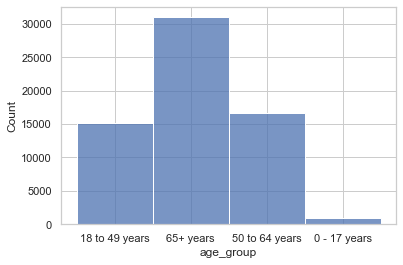

In [143]:
sns.histplot(compare_false['age_group'])

In [144]:
state_compare = pd.DataFrame(compare_false.groupby('res_state').count()['preds'].sort_values(ascending=False))
state_compare.reset_index(inplace=True)
state_compare.head()

,res_state,preds
0,CA,10911
1,FL,7561
2,NJ,6771
3,OH,4778
4,AZ,4037


<AxesSubplot:xlabel='preds', ylabel='res_state'>

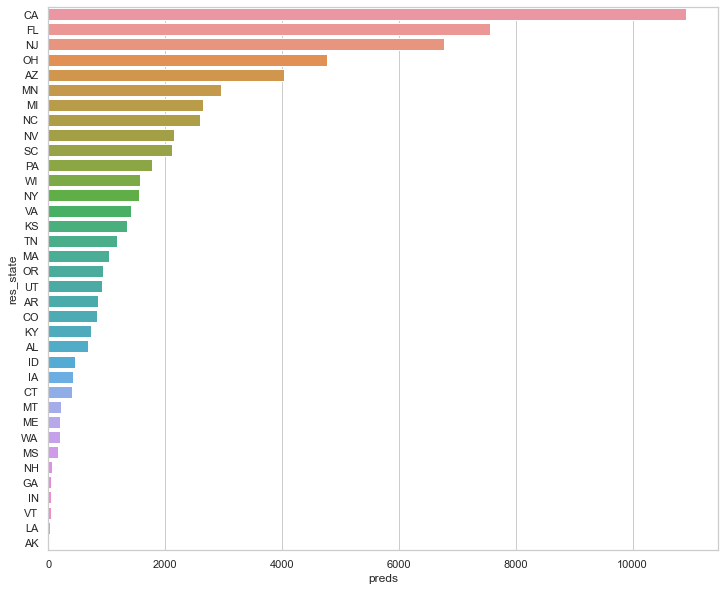

In [145]:
plt.figure(figsize = (12,10))
sns.barplot(data=state_compare, y='res_state', x='preds', orient='h')

<a id='Conclusions-&-Recommendations'></a>

### 6) Conclusions & Recommendations

We can accurately predict whether a probable COVID case will be admitted to the hospital with an accuracy of ~93.2%.
It was difficult to create an accurate prediction that would perform better than our baseline accuracy of ~92.6%.
Through the process of cleaning our data and exploring different predictive modeling techniques, we did slightly better than our baseline, but also had interesting findings.

We notice all the different correlative features that contribute the most to hospitalization: age group, location, and race. 
If conducting a similar project, I would recommend gathering even more data from the CDC across a larger span of time that COVID has been present. Also, there are many states that are under-reporting COVID data for unspecified reasons, this can cause inaccuracy in our analysis. Data sets with less Null values would fair better. 

<a id='Areas-for-Further-Research/Study'></a>

### 7) Areas for Further Research/Study

It would be interesting to see what results a similar analysis would bring a year from now in 2022, as we are entering the final stages of the pandemic.

It would also be interesting to bring in more features that weren't available in this data set that may have a large impact on COVID hospitalization.